In [38]:
DATA_PATH = "data/UrbanSound8K"
PROCESSED_DATA_PATH = "data/1d_processed"

In [39]:
import pandas as pd
import os.path
import librosa as lr
import librosa.display as lrdsp
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras


In [40]:
def load_info():
    """Loads the csv file to a numpy table.
     
    | filename | salience | fold | classID |
    """
    csv = pd.read_csv(os.path.join(DATA_PATH, "UrbanSound8K.csv"))
    csv = csv.drop(labels=["fsID", "start", "end", "class"], axis=1)
    csv = csv.to_numpy()
    return csv

def load_file_index(csv, index):
    """Load the wav file at `csv[index]`, return the wave, sr, and classID."""
    path = os.path.join(DATA_PATH, "fold{}".format(csv[index][2]), csv[index][0])
    wave, sr = lr.load(path)
    class_id = csv[index][3]
    return (wave, sr, class_id)

def load_file_row(csv_row):
    """Load the wav file at `csv[index]`, return the wave, sr, and classID."""
    path = os.path.join(DATA_PATH, "fold{}".format(csv_row[2]), csv_row[0])
    wave, sr = lr.load(path)
    class_id = csv_row[3]
    return (wave, sr, class_id)

classes = [
    "air_conditioning",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gunshot",
    "jackhammer",
    "siren",
    "street_music",
]

In [41]:
csv = load_info()

In [42]:
INPUT_SHAPE = 256
def preprocess(wave, sr):
    spec = lr.feature.melspectrogram(wave, sr=sr, n_mels=INPUT_SHAPE)
    freq_mean_power = np.mean(spec, axis=1)
    return freq_mean_power

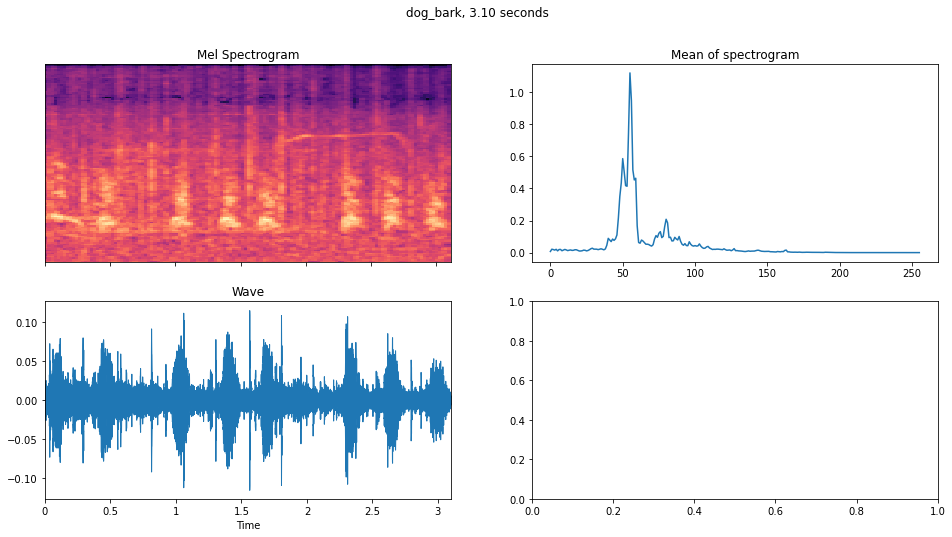

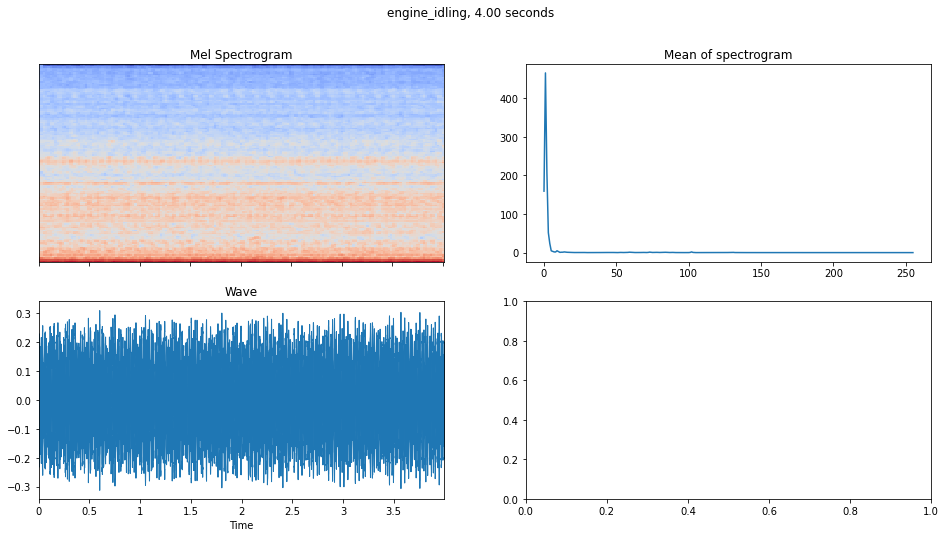

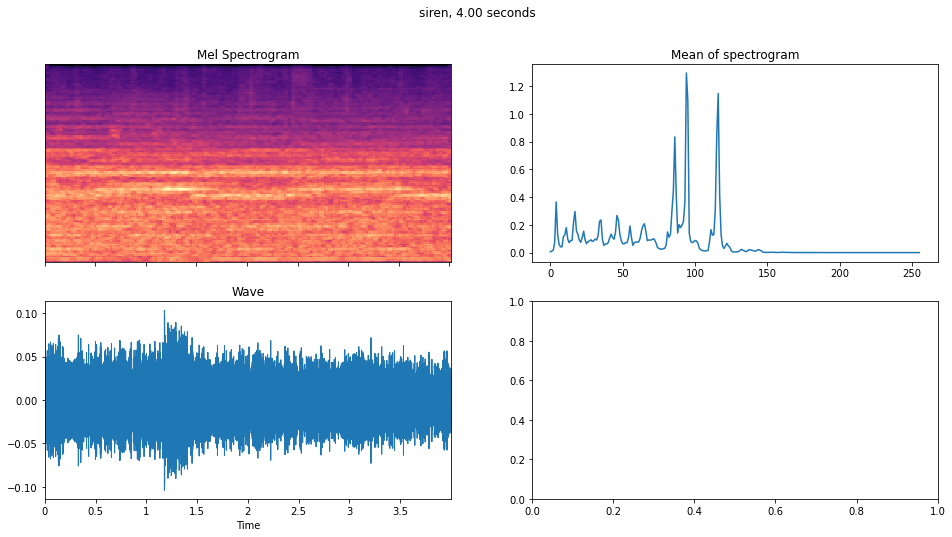

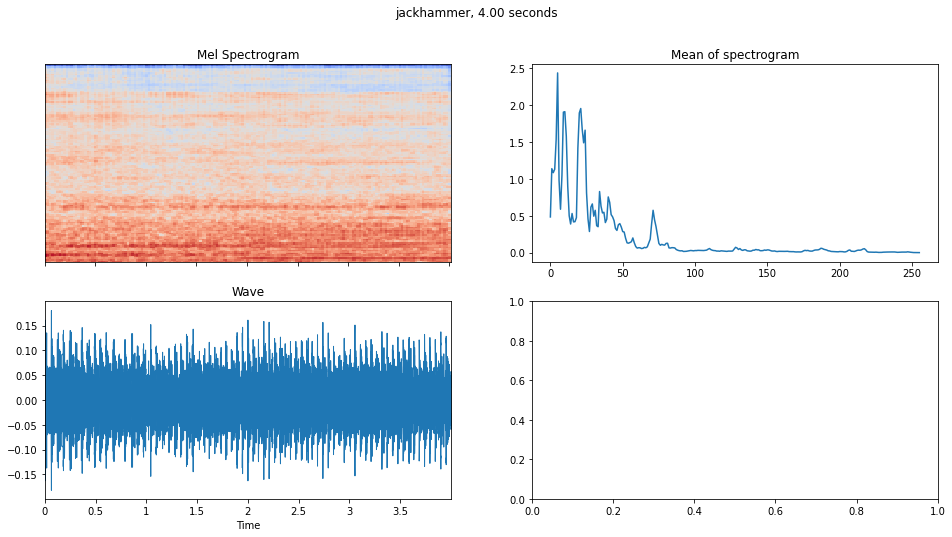

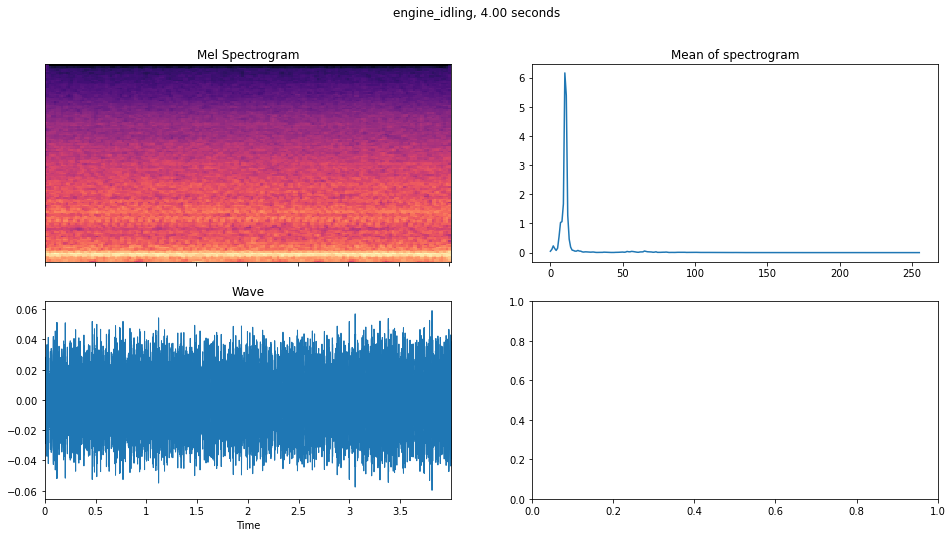

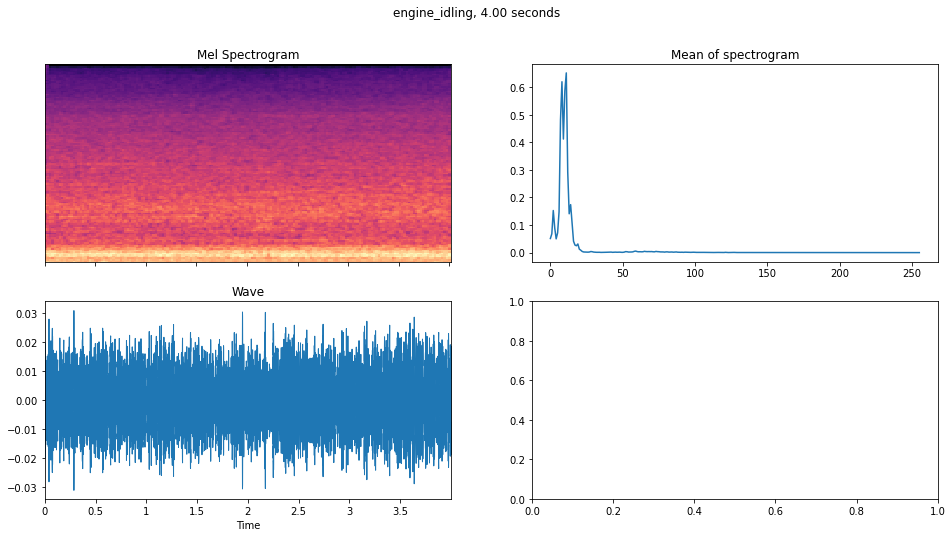

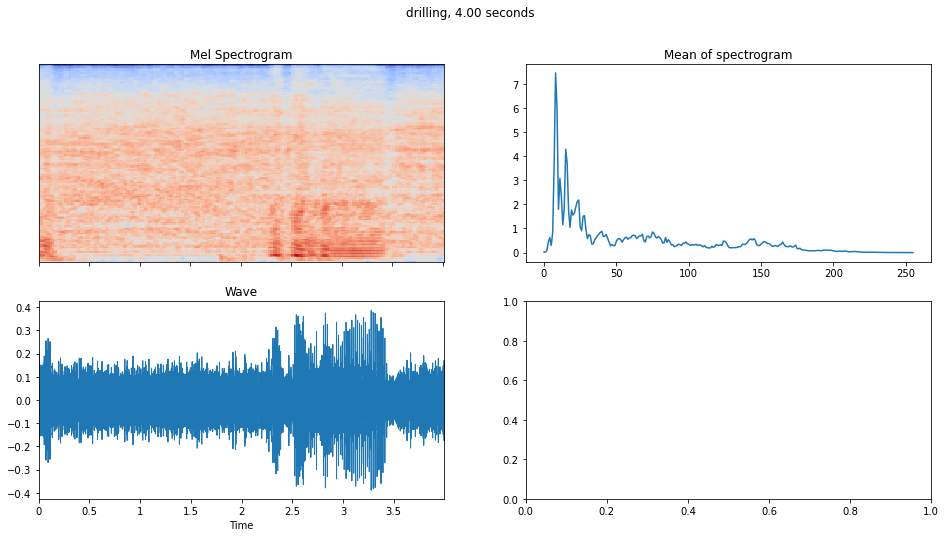

In [43]:
for i in range(100,300,30):
    wave, sr, c = load_file_index(csv, i)
    spec = lr.feature.melspectrogram(wave, sr=sr)
    spec_db = lr.power_to_db(spec)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
    fig.suptitle("{}, {:.2f} seconds".format(classes[c], len(wave)/sr))

    lrdsp.specshow(spec_db, sr=sr, ax=ax[0,0], x_axis="time")
    ax[0,0].set(title="Mel Spectrogram")
    ax[0,0].label_outer()

    lrdsp.waveplot(wave, sr=sr, ax=ax[1,0], x_axis="time")
    ax[1,0].set(title="Wave")
    
    ax[0,1].plot(preprocess(wave, sr))
    ax[0,1].set(title="Mean of spectrogram")

We will preprocess data by taking the mean of a spectrogram along axis 1. That is, the mean power over time for each frequency. This makes the input have a single size, that does not depend on the length of the fragment. However, we lose all information of change over time.

We load in preprocessed data, or create it if necessary.

In [16]:
X_folds = np.empty((0,873,INPUT_SHAPE))
y_folds = np.empty((0,873))
if not os.path.exists(PROCESSED_DATA_PATH):
    print("Preprocessing data, this will take some time...")
    os.mkdir(PROCESSED_DATA_PATH)
    for i in range(1,11):
        fold_csv = csv[csv[:,2]==1]
        print("Fold {}, {} files:".format(i, len(fold_csv)))
        X = np.empty((0,INPUT_SHAPE))
        y = np.empty(0)
        for j, row in enumerate(fold_csv):
            wave, sr, c = load_file_row(row)
            
            data = preprocess(wave, sr)

            X = np.append(X, data[np.newaxis], axis=0)
            y = np.append(y, c)
            print(".", end="", flush=True)
            if (j+1) % 100 == 0:
                print("")
    
        np.savez(os.path.join(PROCESSED_DATA_PATH, "fold{}".format(i)), X=X, y=y)
        print("\nStored fold{} data in {}".format(i, os.path.join(PROCESSED_DATA_PATH, "fold{}.npz".format(i))))

        X_folds = np.append(X_folds, X[np.newaxis], axis=0)
        y_folds = np.append(y_folds, y[np.newaxis], axis=0)

else:
    print("Processed data directory found, proceeding to read it in...")
    for i in range(1,11):
        data = np.load(os.path.join(PROCESSED_DATA_PATH, "fold{}.npz".format(i)))
        print(".", end="", flush=True)

        X_folds = np.append(X_folds, data["X"][np.newaxis], axis=0)
        y_folds = np.append(y_folds, data["y"][np.newaxis], axis=0)

Processed data directory found, proceeding to read it in...
..........

Now we define how our model should work.

In [17]:
def build_model():
    keras.backend.clear_session()

    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(INPUT_SHAPE,1)))

    # Convolution layers
    model.add(keras.layers.Conv1D(32, 15))
    model.add(keras.layers.MaxPooling1D(pool_size=3, strides=3))
    model.add(keras.layers.Activation(activation="relu"))
    # model.add(keras.layers.Conv1D(64, 3,activation="relu"))
    model.add(keras.layers.Conv1D(64, 3,activation="relu"))
    model.add(keras.layers.Flatten())

    # Dense layers
    # model.add(keras.layers.Dense(512, activation="sigmoid"))
    model.add(keras.layers.Dense(256, activation="sigmoid"))
    model.add(keras.layers.Dense(256, activation="sigmoid"))
    # model.add(keras.layers.Dense(128, activation="sigmoid"))
    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(5e-4), 
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    return model

BATCH_SIZE = 24

model = build_model()

model.summary()



And we test it on a single train-test split, just so we can see some quick results:

In [18]:
t = 9

X_train = np.concatenate(np.append(X_folds[:t], X_folds[t+1:], axis=0))[:,:,np.newaxis]
y_train = keras.utils.to_categorical(np.concatenate(np.append(y_folds[:t], y_folds[t+1:], axis=0)))
X_test = X_folds[t][:,:,np.newaxis]
y_test = keras.utils.to_categorical(y_folds[t])

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=15,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
)




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 242, 32)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 80, 32)            0         
_________________________________________________________________
activation (Activation)      (None, 80, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 78, 64)            6208      
_________________________________________________________________
flatten (Flatten)            (None, 4992)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1278208   
____

In [19]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("")

    def on_epoch_begin(self, epoch, logs=None):
        print("  Epoch {}: ".format(epoch+1), end="", flush=True)

    def on_train_batch_end(self, batch, logs=None):
        if batch % 10 == 0:
            print(".", end="", flush=True)

histories = []
for t in range(10):
    print("Fold {} of 10:".format(t+1))
    X_train = np.concatenate(np.append(X_folds[:t], X_folds[t+1:], axis=0))[:,:,np.newaxis]
    y_train = keras.utils.to_categorical(np.concatenate(np.append(y_folds[:t], y_folds[t+1:], axis=0)))
    X_test = X_folds[t][:,:,np.newaxis]
    y_test = keras.utils.to_categorical(y_folds[t])

    model = build_model()
    histories.append(model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=15,
        verbose=0,
        validation_data=(X_test, y_test),
        shuffle=True,
        callbacks=[CustomCallback()]
    ))


Fold 1 of 10:
  Epoch 1: .................................
  Epoch 2: .................................
  Epoch 3: .................................
  Epoch 4: .................................
  Epoch 5: .................................
  Epoch 6: .................................
  Epoch 7: .................................
  Epoch 8: .................................
  Epoch 9: .................................
  Epoch 10: .................................
  Epoch 11: .................................
  Epoch 12: .................................
  Epoch 13: .................................
  Epoch 14: .................................
  Epoch 15: .................................
Fold 2 of 10:
  Epoch 1: .................................
  Epoch 2: .................................
  Epoch 3: .................................
  Epoch 4: .................................
  Epoch 5: .................................
  Epoch 6: .................................
  Epoch 7: ..........

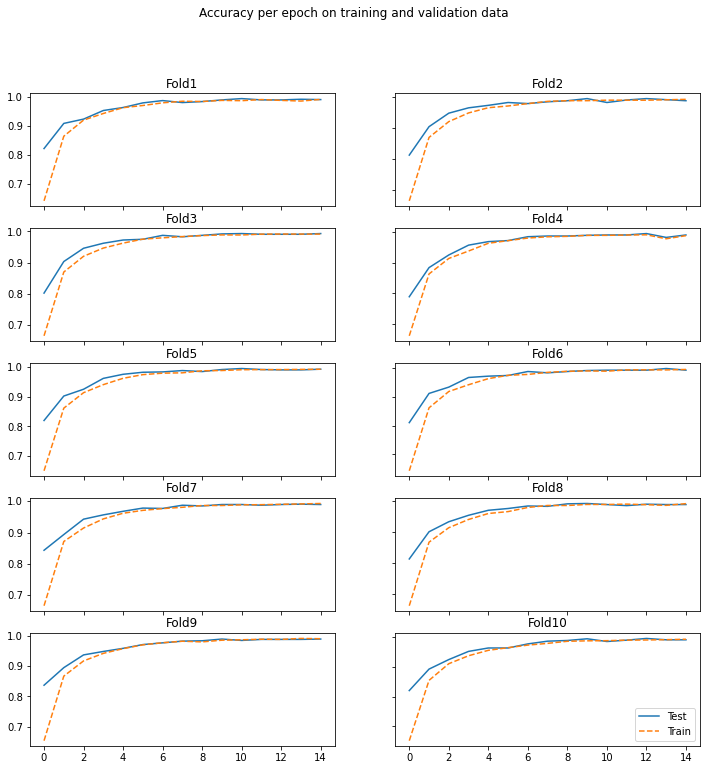

Average validation accuracy: 0.9905
Average training accuracy: 0.9918


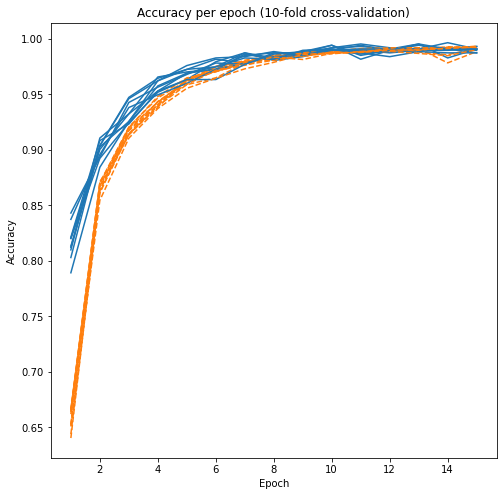

In [20]:
fig, ax = plt.subplots(nrows=5,ncols=2, figsize=(12,12))
fig.suptitle("Accuracy per epoch on training and validation data")

avg_val_acc = 0
avg_acc = 0

for i in range(10):
    avg_val_acc += histories[i].history["val_acc"][-1]
    avg_acc += histories[i].history["acc"][-1]
    ax[i//2,i%2].plot(histories[i].history["val_acc"], label="Test")
    ax[i//2,i%2].plot(histories[i].history["acc"], linestyle="dashed", label="Train")
    ax[i//2,i%2].set(title="Fold{}".format(i+1))
    ax[i//2,i%2].label_outer()
plt.legend()
plt.show()

avg_val_acc /= 10
avg_acc /= 10

print("Average validation accuracy: {:.4f}".format(avg_val_acc))
print("Average training accuracy: {:.4f}".format(avg_acc))

plt.figure(figsize=(8,8))
plt.title("Accuracy per epoch (10-fold cross-validation)")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
for i in range(10):
    plt.plot(range(1,16), histories[i].history["val_acc"], color="tab:blue", label="Test")
    plt.plot(range(1,16),histories[i].history["acc"], color="tab:orange", linestyle="dashed", label="Train")

We typically achieve about 99% accuracy after 15 epochs using only the mean of the melspectrograms, so without any information about time. It seems suspicious that we get such good results with a relatively simple network (with more frequency bands and more/bigger layers we can probably increase performance even a bit more, though bounded by the law of diminishing returns). However, there validation accuracy never much lower than the training accuracy, so there is no overfitting here. In real life applications, it is unlikely that using the mean of a spectrogram gives good results, as the UrbanSound8K dataset is a very simplistic set, having only 10 classes.